**Fashion MNIST- CNN Model Prediction using Pytorch**

[Original Work](https://www.kaggle.com/tinydman/fashion-mnist-with-pytorch/data)

In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "/input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

To begin with , import same necessary third party libraries and parameters

In [11]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision

In [12]:
print(torch.__version__)

1.1.0


**First build your own dataset and read the csv file into it**

In [13]:
data_train = pd.read_csv('./input/fashion-mnist_train.csv')
data_test = pd.read_csv('./input/fashion-mnist_test.csv')

In [14]:
data_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
class MyDataset(Dataset):
    '''
    Build your own dataset
    '''
    def __init__(self, data, transform = None):
        self.fashion_mnist = list(data.values)
        self.transform = transform
        label, img = [],[]
        for one_line in self.fashion_mnist:
            label.append(one_line[0])
            img.append(one_line[1:])
        self.label = np.asarray(label)
        self.img = np.asarray(img).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNEL).astype('float32')

    def __getitem__(self, item):
        label, img = self.label[item], self.img[item]
        if self.transform is not None:
            img = self.transform(img)

        return label, img

    def __len__(self):
        return len(self.label)

And now load our data and prepare for train 

In [16]:
BATCH_SIZE = 50
LR = 0.005
NUM_CLASS = 10
IMAGE_SIZE = 28
CHANNEL = 1
Train_epoch = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CLASS_CLOTHING = {0 :'T-shirt/top',
                  1 :'Trouser',
                  2 :'Pullover',
                  3 :'Dress',
                  4 :'Coat',
                  5 :'Sandal',
                  6 :'Shirt',
                  7 :'Sneaker',
                  8 :'Bag',
                  9 :'Ankle boot'}

In [17]:
My_transform = transforms.Compose([
    transforms.ToTensor(),# default : range [0, 255] -> [0.0,1.0]
])

Train_data = MyDataset(data_train, transform=My_transform)
Test_data = MyDataset(data_test, transform=My_transform)

Train_dataloader = DataLoader(dataset=Train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=False
                              )
Test_dataloader = DataLoader(dataset=Test_data,
                              batch_size = BATCH_SIZE,
                              shuffle=False
                              )

At this time we can show some images in this Dataloader

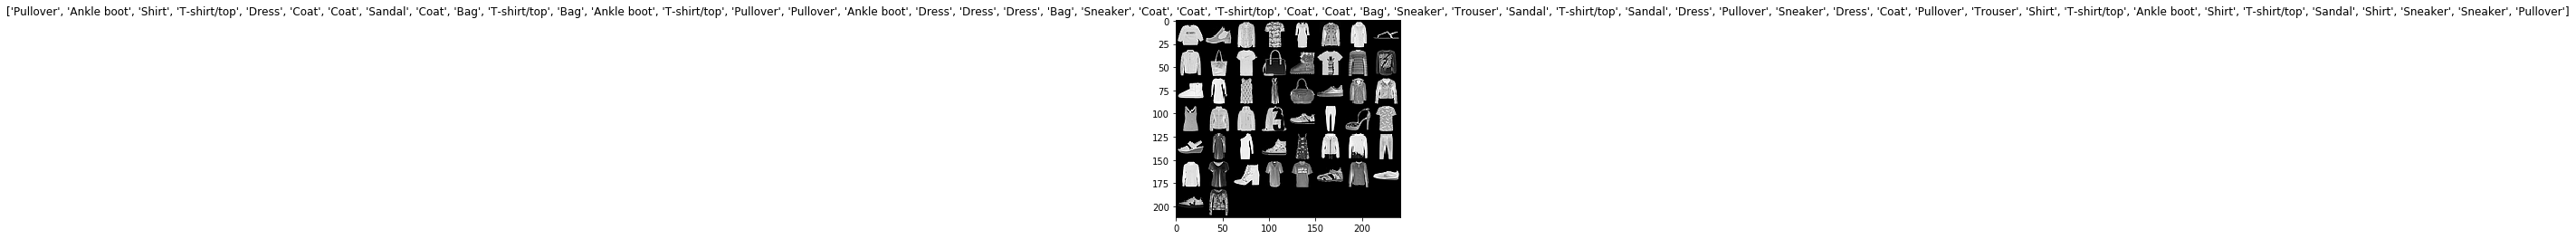

In [18]:
data_iter = iter(Train_dataloader)# at this time I set batch_size = 4
label , img = next(data_iter)

def imshow(img, title):
    img = torchvision.utils.make_grid(img)/255
    img = img.numpy().transpose([1, 2, 0])
    plt.imshow(img)
    if title is not None:
        plt.title(title)

imshow(img, [CLASS_CLOTHING[x] for x in label.numpy().tolist()])
plt.show()

Now define our model and train ! 


And then we load the model and see how model act on the test dataset.

In [19]:
class My_Model(nn.Module):
    def __init__(self, num_of_class):
        super(My_Model, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [20]:
def train():
    model = My_Model(NUM_CLASS).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(1, Train_epoch + 1):
        for batch_id, (label, image) in enumerate(Train_dataloader):
            label, image = label.to(device), image.to(device)
            output = model(image)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_id % 1000 == 0:
                print('Loss :{:.4f} Epoch[{}/{}]'.format(loss.item(), epoch, Train_epoch))
    return model

In [21]:
def test(model):
    with torch.no_grad():
        correct = 0
        total = 0
        for label , image in Test_dataloader:
            image = image.to(device)
            label = label.to(device)
            outputs = model(image)
            predicted = torch.argmax(outputs,dim=1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [22]:
if __name__ == '__main__':
    model = train()
    test(model)

Loss :2.3573 Epoch[1/5]
Loss :0.3456 Epoch[1/5]
Loss :0.3969 Epoch[2/5]
Loss :0.2748 Epoch[2/5]
Loss :0.4064 Epoch[3/5]
Loss :0.2682 Epoch[3/5]
Loss :0.3826 Epoch[4/5]
Loss :0.2369 Epoch[4/5]
Loss :0.3857 Epoch[5/5]
Loss :0.2411 Epoch[5/5]
Test Accuracy of the model on the test images: 90.05 %


### Replace Layers

In [53]:
def convert_layers(model, num_to_convert, layer_type_old, layer_type_new, convert_weights=False):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name], num_converted = convert_layers(model=module, num_to_convert= (num_to_convert-conversion_count),
                                                                 layer_type_old = layer_type_old,
                                                                 layer_type_new = layer_type_new,
                                                                 convert_weights = convert_weights)
            conversion_count += num_converted

        if type(module) == layer_type_old and conversion_count < num_to_convert:
            layer_old = module
            layer_new =  layer_type_new(module.num_features, module.eps, module.momentum, module.affine, module.track_running_stats)
            
            #for conv2d
            """
            layer_new = layer_type_new(module.in_channels, module.out_channels, module.kernel_size, module.stride,
                                             module.padding, module.dilation, module.groups,
            
                                          module.bias is not None, module.padding_mode) 
            """

            if convert_weights == True:
                layer_new.weight = layer_old.weight
                layer_new.bias = layer_old.bias

            model._modules[name] = layer_new
            conversion_count += 1

    return model, conversion_count

In [32]:
def copy_model(model, *args):
    model_copy = type(model)(*args) # get a new instance
    model_copy.load_state_dict(model.state_dict()) # copy weights and stuff
    
    return model_copy

In [54]:
n_model = copy_model(model, NUM_CLASS)

In [55]:
n_model.eval()
n_model

My_Model(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [56]:
class BatchNorm2d(nn.BatchNorm2d):
    def forward(self, x):
        self._check_input_dim(x)
        y = x.transpose(0,1)
        return_shape = y.shape
        y = y.contiguous().view(x.size(1), -1)
        mu = y.mean(dim=1)
        sigma2 = y.var(dim=1)
        if self.training is not True:
            y = y - self.running_mean.view(-1, 1)
            y = y / (self.running_var.view(-1, 1)**.5 + self.eps)
        else:
            if self.track_running_stats is True:
                with torch.no_grad():
                    self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*mu
                    self.running_var = (1-self.momentum)*self.running_var + self.momentum*sigma2
            y = y - mu.view(-1,1)
            y = y / (sigma2.view(-1,1)**.5 + self.eps)

        y = self.weight.view(-1, 1) * y + self.bias.view(-1, 1)
        return y.view(return_shape).transpose(0,1)

In [44]:

def print_module_items(n_model):
    for name, module in reversed(n_model._modules.items()):
        print("Name {}, module {}, type {}".format(name,module, type(module)))
        if len(list(module.children())) > 0:
            # recurse
            print_module_items( module   )
        

In [94]:
#print_module_items(n_model)

### Replace batchnorm2d with custom.

In [57]:
new_model, count = convert_layers(model =n_model,
                                  num_to_convert = 3,
                                  layer_type_old =nn.BatchNorm2d ,
                                  layer_type_new = BatchNorm2d,
                                  convert_weights=False)
new_model, count

(My_Model(
   (layer1): Sequential(
     (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (layer2): Sequential(
     (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc): Linear(in_features=1568, out_features=10, bias=True)
 ), 2)

In [58]:
print_module_items(new_model)

Name fc, module Linear(in_features=1568, out_features=10, bias=True), type <class 'torch.nn.modules.linear.Linear'>
Name layer2, module Sequential(
  (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
), type <class 'torch.nn.modules.container.Sequential'>
Name 3, module MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), type <class 'torch.nn.modules.pooling.MaxPool2d'>
Name 2, module ReLU(), type <class 'torch.nn.modules.activation.ReLU'>
Name 1, module BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), type <class '__main__.BatchNorm2d'>
Name 0, module Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)), type <class 'torch.nn.modules.conv.Conv2d'>
Name layer1, module Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5

True Label Shirt, predicted label Shirt


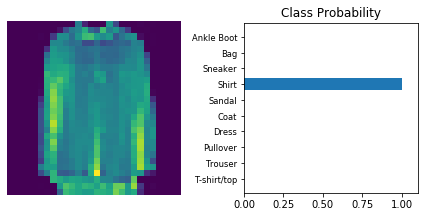

In [95]:
from helper import *

labels,images = next(iter(Test_dataloader))

preds = new_model(images)

ps = torch.softmax(preds, dim = 1 )

INDEX = 7



print("True Label {}, predicted label {}".format( CLASS_CLOTHING[labels[INDEX].item()],CLASS_CLOTHING[torch.argmax(ps[INDEX]).item()]))
view_classify(images[INDEX], ps[INDEX],version = 'Fashion')
